# Is there a Tipping Point?

## Introduction

In a very popular book titled *The Tipping Point*, Malcom Gladwell put forth a rather powerful idea. He makes the observation that among the entire set of new ideas that populate the world from various sources, the subset that eventually become popular share a set of common traits. He categorizes these traits into three central concepts that underlie any successful idea. 

**Law of the Few** A few specific set of people (Mavens, Salesmen and Connectors) must champion the cause. If these people endorse the idea, the chance of exponential success is higher

**Stickiness Factor** The strength of the idea itself and how sticky it is in the minds of the users

**Power of Context** The success of the idea also depends crucially on the general environment prevailing at the time. When the audience is not ready, even the best ideas can bite the dust

The publication of this work led to the creation of a cottage industry of *influencers*. This trend was in large part fueled by eager marketers searching for the set of people whose endorsement can push their product to success. In this workbook, we take a close look at this *influential hypothesis*, i.e., the idea that a specific set of people (e.g., the most connected) are able to drive the diffusion of ideas/products at a much larger scale compared to 'average' people. We also wish to estimate the impact of these influencers by measuring the difference in the scale of diffusion achieved by influencer marketing. The simulation based approach demonstrated in this workbook is based on an interesting paper:

Watts, D. J., & Dodds, P. S. (2007). Influentials, networks, and public opinion formation. Journal of consumer research, 34(4), 441-458.

We note that since only a minimal description of the simulation design is presented in this paper, this workbook is not a complete replication but only our interpretation. We refer readers to Prof. James P Gleeson's [work](http://www3.ul.ie/gleesonj/) for some awesome MATLAB code that inspired this tutorial. Also, it might be beneficial to run through an [earlier tutorial](https://github.com/JuliaGraphs/JuliaGraphsTutorials/blob/master/Watts-Model.ipynb) before jumping in to this one.   

In [1]:
using Pkg
for pkg in ["Graphs", "Plots", "GR", "DataFrames"]
    Pkg.add(pkg)
end

    Updating registry at `C:\Users\Thibaut\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Manifest.toml`


In [2]:
using Distributions
using Graphs
using Plots
using DataFrames
using Random: shuffle, seed!

gr(size = (800, 400), alpha = 0.8)
seed!(20130810);

Before we begin our exploration, it is instructive to look at the degree distribution of the underlying network on which we simulate the diffusion process. At the outset, note that we focus only on networks that have a power law distribution of node degrees in this workbook. This means that while most nodes have a small degree, there is a finite probability that some nodes have very high degree. We note that several empirical network distributions (hosted at http://konect.uni-koblenz.de/plots/degree_distribution) are networks with heavy-tailed distributions. In this context, our assumption of power law distribution of degrees is not way off-mark.

Let us begin by plotting degree distributions of a few Barabasi-Albert graphs using the builtin graph generator from Graphs. First, notice the correspondence between the inputs to the graph generator and the average degree of the graph 

In [3]:
N = 10^4 # Number of nodes in the network

zs = [mean(degree(barabasi_albert(N, k))) for k in (2, 6, 12, 16)] # average degrees of the graphs

4-element Vector{Float64}:
  3.9992
 11.9928
 23.9712
 31.9488

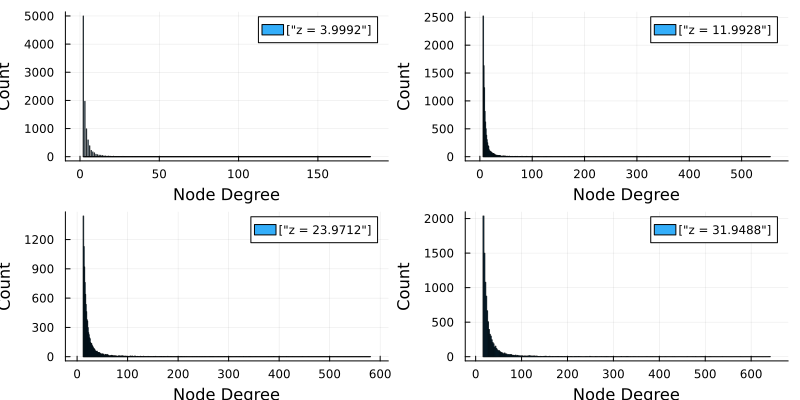

In [4]:
p1 = histogram(degree(barabasi_albert(N, 2)), label = ["z = $(zs[1])"]) 
p2 = histogram(degree(barabasi_albert(N, 6)), label = ["z = $(zs[2])"]) 
p3 = histogram(degree(barabasi_albert(N, 12)), label = ["z = $(zs[3])"]) 
p4 = histogram(degree(barabasi_albert(N, 16)), label = ["z = $(zs[4])"]) 

plot(p1, p2, p3, p4, layout = 4, xlabel = "Node Degree", ylabel = "Count")

## Model

We model the impact of seeding to specific individuals by running diffusion simulations in two scenarios. In the first scenario, we seed the simulation by activating a randomly chosen node from the network. In the second scenario, we seed the most connected node (i.e., highest degree) in the network.    

We make the following assumptions on the decision making behavior of the nodes in a network (replicated from [this](https://github.com/JuliaGraphs/JuliaGraphsTutorials/blob/master/Watts-Model.ipynb)):

 - A node in a graph is faced with a binary decision - to engage or to not engage (e.g., with new products or discussions with friends)
 - They make this decision based on a simple rule - they compute the fraction of their neighbors that have engaged, compare it with their personal threshold, and engage if the fraction of engaged neighbors exceeds the threshold. In other words, the thought process is on the lines, "If at least 18% of my friends bought the new iPhone, I would want to buy it too"
 - The execution of this model is random and asynchronous, i.e., each node checks the status of its neighbors in a random order and decides whether to engage or not depending on the fraction of neighbors engaged at that point

In [5]:
function fraction_engaged(node::Int,
                          G::Graphs.SimpleGraphs.SimpleGraph,
                          node_status::BitArray)
    """
    Computes the fraction of neighbors engaged within the neighborhood
    of a given node. It uses the node status to check the engagement status of
    each of the nodes neighbors
    """
    num_engaged_neighbors = 0
    for nbr in neighbors(G, node)
        if node_status[nbr] == true
            num_engaged_neighbors += 1
        end
    end
    return num_engaged_neighbors/length(neighbors(G, node))
end

fraction_engaged (generic function with 1 method)

In [6]:
function update_node_status(G::Graphs.SimpleGraphs.SimpleGraph,
                            node_status::BitArray,
                            threshold::Vector{Float64})
    """
    This function executes the random asynchronous updates of the entire network
    at each time step. In this conceptualization, each time step comprises mini
    time steps during which a randomly shuffled node list updates.    
    We store a copy of the node status before the updation. This helps to compare
    precisely what changed in the updation
    """
    old_status = copy(node_status)

    for node in shuffle(vertices(G))
        if node_status[node] == false
            if fraction_engaged(node, G, node_status) > threshold[node]
                node_status[node] = true
            end
        end
    end

    return node_status, old_status
end

update_node_status (generic function with 1 method)

In [7]:
function diffusion_simulation(n::Int,
                              z::Int,
                              threshold::Vector{Float64},
                              n_realizations::Int)
    """
    Create a new Barabasi-Albert graph at each realization. This represents a power law distribution of node degrees and is 
    supposed to be reflective of the influence distribution among the nodes in the network.
    Two kinds of seeding is conducted - seeding the most influential person in the network (e.g., one with maximum degree) 
    and a randomly chosen person in the network.
    The network then updates till no new node activations are possible at this configuration of the network 
    and the threshold. 
    The simulation is executed a large number of times and the cumulative number of activations is counted for each case.
    
    Hyper Parameters of the model
    ----------
    1. Number of nodes in the Barabasi-Albert graph (n)
    2. Average degree (z)
    3. Threshold (distribution or a specific value)
    4. Number of realizations

    Output
    -----------
    A matrix of number of activations in random and influential seeding and time steps to stability for each case at the 
    end of each realization of the simulation

    """

    output = Matrix{Int}(undef, n_realizations, 4)
    k = floor(Int, z/2) # Reason out why this relationship should be true 

    for r in 1:n_realizations
        G = barabasi_albert(n, k) # represents the influence distribution
        
        # Step 1: Explore cascades triggered by random seed
        
        # Select a single random node from the network and seed it
        node_status = falses(nv(G))
        node_status[sample(vertices(G))] = true
        
        t = 1
        new_node_status, node_status = update_node_status(G, node_status, threshold)
        
        # Keep updating node status till there are more nodes to activate
        # This requires us to keep storing the node status vector from one iteration before
        # for comparison. As long as there are more nodes that can be activated, i.e., cascade has not ended, 
        # we keep updating the nodes and incrementing the time steps
        
        while !isequal(new_node_status, node_status)
            node_status = new_node_status
            new_node_status, node_status = update_node_status(G, node_status, threshold)
            t += 1
        end
        
        random_activations, random_timesteps = sum(node_status), t
        
        # Step 2: Explore cascades triggered by most connected seed 

        # Select the node with highest degree and seed it
        # This can be easily modified to rank nodes by other centrality measures
        node_status = falses(nv(G))
        seed = sortperm(degree_centrality(G), rev=true)[1]
        node_status[seed] = true
        
        t = 1
        new_node_status, node_status = update_node_status(G, node_status, threshold)
        
        # Keep updating node status till there are more nodes to activate
 
        while !isequal(new_node_status, node_status)
            node_status = new_node_status
            new_node_status, node_status = update_node_status(G, node_status, threshold)
            t += 1
        end
        
        influential_activations, influential_timesteps = sum(node_status), t
        
        output[r, 1:end] = [random_activations, random_timesteps, influential_activations, influential_timesteps]
    end

    return output

end

diffusion_simulation (generic function with 1 method)

## Results 

We can run the diffusion simulations on the parameter space $(z, \phi)$ where z is the average degree of the network and $\phi$ is the threshold distribution of the nodes in the network. The [degree distribution](https://en.wikipedia.org/wiki/Degree_distribution) of the network is heavy-tailed as discussed earlier. We vary the average degree of the nodes and create several network structures in the process. The threshold distribution can be assumed to be uniform or drawn from a specific probability distribution. 

To illustrate this process, we run the diffusion simulations on 4 pairs of $(z, \phi)$: (4, 0.1), (4, 0.4), (32, 0.1), (32, 0.4). These pairs are reflective of a factorial design with high/low values for network degree and node thresholds. we run the simulations for 100 values at each pair. Of course, we make the simplifying assumption that all nodes in the newtork have the same threshold for activation.

In [8]:
@time data1 = diffusion_simulation(N, 4, fill(0.1, N), 100); # (z, phi) = (4, 0.1) Low threshold, Low degree

  1.034093 seconds (2.08 M allocations: 327.096 MiB, 5.30% gc time, 0.73% compilation time)


In [9]:
@time data2 = diffusion_simulation(N, 4, fill(0.4, N), 100); # (z, phi) = (4, 0.4) Low degree, High threshold

  0.604031 seconds (2.07 M allocations: 249.170 MiB, 4.73% gc time)


In [10]:
@time data3 = diffusion_simulation(N, 32, fill(0.1, N), 100); # (z, phi) = (32, 0.1) High degree, Low threshold

  2.965614 seconds (3.32 M allocations: 1.216 GiB, 5.57% gc time)


In [11]:
@time data4 = diffusion_simulation(N, 32, fill(0.4, N), 100); # (z, phi) = (32, 0.4) High degree, High threshold

  2.886494 seconds (3.32 M allocations: 1.217 GiB, 5.36% gc time)


In [12]:
data = vcat(data1, data2, data3, data4)

d = DataFrame(data[1:end, [1, 3]], :auto)
cols = [:random_activations, :influential_activations]
rename!(d, cols)
d[!, :elevation_in_activations] = d[!, :influential_activations] ./ d[!, :random_activations];

In [13]:
describe(d[!, :elevation_in_activations])

Summary Stats:
Length:         400
Missing Count:  0
Mean:           191.737374
Minimum:        1.000000
1st Quartile:   1.000000
Median:         1.000000
3rd Quartile:   17.250000
Maximum:        10000.000000
Type:           Float64


If we look at the mean elevation across all the simulation runs on the sample space, it looks like influentials provide a big jump in elevation compared to average individuals. This is a big +1 for the *influential hypothesis*. A direct implication of this finding is that most marketing dollars should be directed towards identifying and 'influencing' the influencers. No wonder 'influencer marketing' was the buzz word for several years!  

This is not the full picture though. Averages are severely misleading. A key idea of the Tipping Point is that these 'special' individuals are able to drive large swathes of ordinary individuals into adopting the idea because of their endorsement. Such large scale sequence of adoptions following a single adoption are called *cascades*. To be really effective, influentials should be able to drive cascades that are large not only on average, but also in scale. They have to be really, really, *really* big. The kind of big that poor ordinary individuals cannot generate, ever. These kind of super large cascades are called *global cascades*.  

A reasonable definition of a *global cascade* is one that occupies at least 10% of the network (this is based on prior literaure, but of course it is up to you to pick a cut-off). For the 10,000 node network we consider in this notebook, global cascades are those that reach 1000 nodes. Let us now see how the influencers fare on this metric. 

In [14]:
num_rand_global_cascades = sum(map(x -> x>1000, d[!,:random_activations]))
num_influential_global_cascades = sum(map(x -> x>1000, d[!,:influential_activations]))

num_rand_global_cascades, num_influential_global_cascades

(91, 100)

This is a sobering result from our point of view. Ordinary individuals drive similar numbers of global cascades to influencers. So, do influencers matter?